<a href="https://colab.research.google.com/github/NapoliD/Solucion_Kueski-/blob/main/Moviesv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/grouplens/movielens-20m-dataset

In [ ]:
#En el caso de no tener instalado shap
!pip install shap

In [205]:
# Importamos las bibliotecas a utilizar
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import xgboost as xgb
import shap
import matplotlib.pylab as pl
import os
pd.pandas.set_option('display.max_columns', None)
pd.pandas.set_option('display.max_rows', None)
import seaborn as sns
import statistics

In [2]:
# En el caso de utilizar google drive
from google.colab import drive
drive.mount('/content/drive/') 

Mounted at /content/drive/


In [3]:
# Seteamos ruta
os.chdir('/content/drive/My Drive/')

In [5]:
#Iniciamos con la transformación del .csv ratings
ratings = pd.read_csv('rating.csv')
ratings['Target']=np.where(ratings['rating']>=4,1,0)
ratings=ratings[['movieId','rating','Target']].drop_duplicates()
ratings

,movieId,rating,Target
0,2,3.5,0
1,29,3.5,0
2,32,3.5,0
3,47,3.5,0
4,50,3.5,0
...,...,...,...
19989073,110167,4.5,1
19989075,110510,4.5,1
19990261,118876,2.5,0
19999474,7901,1.5,0


In [41]:
#Seguimos con la transformación del .csv movies, en donde tenemos la oportunidad y seleccionamos los tres principales generos
movies = pd.read_csv('movie.csv')
movies[['genere1','genere2','genere3','genere4','genere5','genere6','genere7','genere8','genere9','genere10']]=pd.DataFrame(movies.genres.str.split('|').tolist())
movies=movies.loc[:,['movieId','title','genres','genere1','genere2','genere3']]
movies['genres']=movies['genres'].str.replace('|',' ')
movies.head(2)

,movieId,title,genres,genere1,genere2,genere3
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,Adventure,Animation,Children
1,2,Jumanji (1995),Adventure Children Fantasy,Adventure,Children,Fantasy


In [42]:
#Evaluamos la mediana porque esa metrica no sufre variabilidad por los outliers
statistics=pd.DataFrame(ratings.groupby(['movieId']).agg(['mean','median','min', 'max','count'])).reset_index(inplace=False)
statistics.columns = [' '.join(col).strip() for col in statistics.columns.values]
statistics=statistics[['movieId','rating mean','rating median','rating min','rating max','rating count']]
statistics.head(5)

,movieId,rating mean,rating median,rating min,rating max,rating count
0,1,2.75,2.75,0.5,5.0,10
1,2,2.75,2.75,0.5,5.0,10
2,3,2.75,2.75,0.5,5.0,10
3,4,2.75,2.75,0.5,5.0,10
4,5,2.75,2.75,0.5,5.0,10


In [43]:
# Aplicamos label_encoder pra poder utilizr el algoritmo XGB label_encoder=movies[['genres','genere1','genere2','genere3']]
le = preprocessing.LabelEncoder()
#le.inverse_transform
for columnas in label_encoder.columns:
  print(columnas)
  label_encoder[columnas]=label_encoder[columnas].astype('str')
  le.fit(label_encoder[columnas])
  movies[columnas+'label']=pd.DataFrame(le.transform(label_encoder[columnas]))
movies

genres
genere1
genere2
genere3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,movieId,title,genres,genere1,genere2,genere3,genreslabel,genere1label,genere2label,genere3label
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,Adventure,Animation,Children,477,2,1,1
1,2,Jumanji (1995),Adventure Children Fantasy,Adventure,Children,Fantasy,564,2,2,6
2,3,Grumpier Old Men (1995),Comedy Romance,Comedy,Romance,None,1028,5,14,12
3,4,Waiting to Exhale (1995),Comedy Drama Romance,Comedy,Drama,Romance,968,5,6,13
4,5,Father of the Bride Part II (1995),Comedy,Comedy,None,None,893,5,13,12
...,...,...,...,...,...,...,...,...,...,...
27273,131254,Kein Bund für's Leben (2007),Comedy,Comedy,None,None,893,5,13,12
27274,131256,"Feuer, Eis & Dosenbier (2002)",Comedy,Comedy,None,None,893,5,13,12
27275,131258,The Pirates (2014),Adventure,Adventure,None,None,467,2,13,12
27276,131260,Rentun Ruusu (2001),(no genres listed),(no genres listed),None,None,0,0,13,12


In [44]:
movies=movies[['movieId', 'genreslabel', 'genere1label', 'genere2label', 'genere3label']]
movies

,movieId,genreslabel,genere1label,genere2label,genere3label
0,1,477,2,1,1
1,2,564,2,2,6
2,3,1028,5,14,12
3,4,968,5,6,13
4,5,893,5,13,12
...,...,...,...,...,...
27273,131254,893,5,13,12
27274,131256,893,5,13,12
27275,131258,467,2,13,12
27276,131260,0,0,13,12


In [45]:
movieId_ratings = pd.merge(movies, statistics, on='movieId')
movieId_ratings

,movieId,genreslabel,genere1label,genere2label,genere3label,rating mean,rating median,rating min,rating max,rating count
0,1,477,2,1,1,2.75,2.75,0.5,5.0,10
1,2,564,2,2,6,2.75,2.75,0.5,5.0,10
2,3,1028,5,14,12,2.75,2.75,0.5,5.0,10
3,4,968,5,6,13,2.75,2.75,0.5,5.0,10
4,5,893,5,13,12,2.75,2.75,0.5,5.0,10
...,...,...,...,...,...,...,...,...,...,...
26739,131254,893,5,13,12,4.00,4.00,4.0,4.0,1
26740,131256,893,5,13,12,4.00,4.00,4.0,4.0,1
26741,131258,467,2,13,12,2.50,2.50,2.5,2.5,1
26742,131260,0,0,13,12,3.00,3.00,3.0,3.0,1


In [46]:
# Preparamos el archivo .csv tag y realizamos un poco de limpieza de texto
tag = pd.read_csv('tag.csv')
tag['Cant_letras']=tag['tag'].str.len()
tag['tag_limp'] = tag['tag'].str.replace('?', ' ')
tag['tag_limp'] = tag['tag'].str.replace('.', ' ')
tag['tag_limp'] = tag['tag'].str.replace(',', ' ')
tag['tag_limp'] = tag['tag'].str.replace('!', '')
tag['tag_limp'] = tag['tag'].str.replace(')', '')
tag['tag_limp'] = tag['tag'].str.replace('(', '')
tag['tag_limp'] = tag['tag'].str.replace('-', '')
tag['tag_limp'] = tag['tag'].str.replace('\d+', '')
tag['tag_limp'] = tag['tag'].str.replace(' ', '')
tag['tag_limp'] = tag['tag'].str.lower()
tag.head()

,userId,movieId,tag,timestamp,Cant_letras,tag_limp
0,18,4141,Mark Waters,2009-04-24 18:19:40,11.0,mark waters
1,65,208,dark hero,2013-05-10 01:41:18,9.0,dark hero
2,65,353,dark hero,2013-05-10 01:41:19,9.0,dark hero
3,65,521,noir thriller,2013-05-10 01:39:43,13.0,noir thriller
4,65,592,dark hero,2013-05-10 01:41:18,9.0,dark hero


In [47]:
#Evaluamos los principales Tags
Cant_tags=pd.DataFrame(tag.groupby('tag')['movieId'].agg(['count'])).reset_index(inplace=False)
tag = pd.merge(tag, Cant_tags, on='tag')
tag=tag[['movieId','tag_limp','Cant_letras','count']].drop_duplicates()
tag=tag[tag['count']>1000]
tag=tag[tag['Cant_letras']<15]
le = preprocessing.LabelEncoder()
le.fit(tag['tag_limp'].astype('str'))
tag['tag_limp_label']=le.transform(tag['tag_limp'])
tag=pd.concat([tag.reset_index(drop=True),
                      (pd.get_dummies(tag["tag_limp"])).astype(int).reset_index(drop=True)], axis=1)
tag


,movieId,tag_limp,Cant_letras,count,tag_limp_label,action,adventure,aliens,animation,atmospheric,bd-r,betamax,black comedy,classic,clv,comedy,criterion,cult film,dark,dark comedy,disturbing,drama,drugs,dystopia,fantasy,funny,imdb top 250,predictable,psychology,quirky,romance,satire,sci-fi,space,stylized,superhero,surreal,tense,thriller,time travel,true story,twist ending,violence,world war ii
0,48082,surreal,7.0,2427,31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,4878,surreal,7.0,2427,31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,1175,surreal,7.0,2427,31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,3000,surreal,7.0,2427,31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,48043,surreal,7.0,2427,31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15905,104733,clv,3.0,1199,9,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15906,104969,clv,3.0,1199,9,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15907,105049,clv,3.0,1199,9,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15908,118722,clv,3.0,1199,9,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [48]:
#Esta etapa se puede automarizar con algun filtro duro, pero para avanzar lo hago a mano
tag=tag[['movieId', 'Cant_letras', 'count', 'tag_limp_label',
       'action', 'adventure', 'aliens', 'animation', 'atmospheric', 'bd-r',
       'betamax', 'black comedy', 'classic', 'clv', 'comedy', 'criterion',
       'cult film', 'dark', 'dark comedy', 'disturbing', 'drama', 'drugs',
       'dystopia', 'fantasy', 'funny', 'imdb top 250', 'predictable',
       'psychology', 'quirky', 'romance', 'satire', 'sci-fi', 'space',
       'stylized', 'superhero', 'surreal', 'tense', 'thriller', 'time travel',
       'true story', 'twist ending', 'violence', 'world war ii']]

In [49]:
#Junto todo en un gran dataset
movieId_ratings = pd.merge(movieId_ratings,tag, on='movieId')
movieId_ratings

,movieId,genreslabel,genere1label,genere2label,genere3label,rating mean,rating median,rating min,rating max,rating count,Cant_letras,count,tag_limp_label,action,adventure,aliens,animation,atmospheric,bd-r,betamax,black comedy,classic,clv,comedy,criterion,cult film,dark,dark comedy,disturbing,drama,drugs,dystopia,fantasy,funny,imdb top 250,predictable,psychology,quirky,romance,satire,sci-fi,space,stylized,superhero,surreal,tense,thriller,time travel,true story,twist ending,violence,world war ii
0,1,477,2,1,1,2.75,2.75,0.5,5.0,10,9.0,1229,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,477,2,1,1,2.75,2.75,0.5,5.0,10,6.0,2779,10,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,477,2,1,1,2.75,2.75,0.5,5.0,10,11.0,1549,34,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,1,477,2,1,1,2.75,2.75,0.5,5.0,10,5.0,2072,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,477,2,1,1,2.75,2.75,0.5,5.0,10,7.0,1769,8,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15817,128991,785,3,3,14,4.25,4.25,4.0,4.5,2,6.0,2779,10,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15818,128991,785,3,3,14,4.25,4.25,4.0,4.5,2,6.0,3384,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
15819,129857,1222,8,14,12,3.00,3.00,3.0,3.0,1,7.0,1534,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
15820,130444,566,2,2,6,1.50,1.50,1.5,1.5,1,11.0,1549,34,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [51]:
my_df = pd.merge(ratings, movieId_ratings, on='movieId')
my_df.head()

,movieId,rating,Target,genreslabel,genere1label,genere2label,genere3label,rating mean,rating median,rating min,rating max,rating count,Cant_letras,count,tag_limp_label,action,adventure,aliens,animation,atmospheric,bd-r,betamax,black comedy,classic,clv,comedy,criterion,cult film,dark,dark comedy,disturbing,drama,drugs,dystopia,fantasy,funny,imdb top 250,predictable,psychology,quirky,romance,satire,sci-fi,space,stylized,superhero,surreal,tense,thriller,time travel,true story,twist ending,violence,world war ii
0,2,3.5,0,564,2,2,6,2.75,2.75,0.5,5.0,10,11.0,1549,34,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,2,3.5,0,564,2,2,6,2.75,2.75,0.5,5.0,10,7.0,1703,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,3.5,0,564,2,2,6,2.75,2.75,0.5,5.0,10,9.0,1243,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2,3.5,0,564,2,2,6,2.75,2.75,0.5,5.0,10,3.0,1199,9,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2,3.0,0,564,2,2,6,2.75,2.75,0.5,5.0,10,11.0,1549,34,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [52]:
#Guardo el dataset modelado
my_df.to_csv('Base.csv')#encoding='latin-1',decimal=',')
#my_df = pd.read_csv('Base.csv')

In [153]:
#Selecciono las columnas para el entrenamiento
my_df_=my_df[['movieId','rating median', 'genreslabel', 'genere1label',
       'genere2label', 'genere3label',  'count',
       'tag_limp_label', 'action', 'adventure', 'aliens', 'animation',
       'atmospheric', 'bd-r', 'betamax', 'black comedy', 'classic', 'clv',
       'comedy', 'criterion', 'cult film', 'dark', 'dark comedy', 'disturbing',
       'drama', 'drugs', 'dystopia', 'fantasy', 'funny', 'imdb top 250',
       'predictable', 'psychology', 'quirky', 'romance', 'satire', 'sci-fi',
       'space', 'stylized', 'superhero', 'surreal', 'tense', 'thriller',
       'time travel', 'true story', 'twist ending', 'violence',
       'world war ii','Target']].drop_duplicates()
my_df_

,movieId,rating median,genreslabel,genere1label,genere2label,genere3label,count,tag_limp_label,action,adventure,aliens,animation,atmospheric,bd-r,betamax,black comedy,classic,clv,comedy,criterion,cult film,dark,dark comedy,disturbing,drama,drugs,dystopia,fantasy,funny,imdb top 250,predictable,psychology,quirky,romance,satire,sci-fi,space,stylized,superhero,surreal,tense,thriller,time travel,true story,twist ending,violence,world war ii,Target
0,2,2.75,564,2,2,6,1549,34,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,2,2.75,564,2,2,6,1703,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,2.75,564,2,2,6,1243,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2,2.75,564,2,2,6,1199,9,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
16,2,2.75,564,2,2,6,1549,34,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141886,111345,3.00,1047,6,6,12,1286,11,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
141887,111349,3.50,1142,8,13,12,1286,11,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
141888,52690,2.50,1293,11,15,12,2334,5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
141889,113466,3.50,1119,7,13,12,1229,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [161]:
#funcion de train y test
def organizar(X,y):
       # Splitting the dataset into the Training set and Test set
       X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)
       return X_train, X_test, y_train, y_test  

In [202]:
X = pd.DataFrame(my_df_.iloc[:, :-1])
y = pd.DataFrame(my_df_.iloc[:, -1])
X_train, X_test, y_train, y_test=organizar(X,y)

In [175]:
# Dado que es un problema de clasificacion utilizamos StandardScaler
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
# Por separado porque sino contaminamos las muestras
X_train_ = sc.fit_transform(X_train)
X_test_ = sc.transform(X_test)

In [176]:
classifier_cl = xgb.XGBClassifier()
classifier_cl=classifier_cl.fit(X_train_, y_train)
y_pred_XGB = classifier_cl.predict(X_test_)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
base_final=pd.concat([y_test.reset_index(drop=True),
                      pd.DataFrame(y_pred_XGB).reset_index(drop=True)], axis=1)
base_final
#y_test['Prediccion']=pd.DataFrame(y_pred_XGB)

In [170]:
def Matriz_Confusion(y_test, y_pred_XGB):
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_test, y_pred_XGB)
    from sklearn.metrics import accuracy_score
    ac=accuracy_score(y_test, y_pred_XGB)
    from sklearn.metrics import classification_report
    cr=classification_report(y_test, y_pred_XGB)
    from sklearn.metrics import roc_auc_score
    rc=roc_auc_score(y_test, y_pred_XGB)
    sensibilidad=cm[1,1]/(cm[1,1]+cm[1,0])
    especificidad=cm[0,0]/(cm[0,0]+cm[0,1])
    
    
    return print(cm),print("Acurracy XGB:", ac),print(cr),print("AUC XGB:", rc),print("sensibilidad", sensibilidad),print("especificidad", especificidad)

In [179]:
#Evaluamos el modelo
Matriz_Confusion(y_test, y_pred_XGB)

[[2399 2343]
 [2631 1904]]
Acurracy XGB: 0.4638352915813302
              precision    recall  f1-score   support

           0       0.48      0.51      0.49      4742
           1       0.45      0.42      0.43      4535

    accuracy                           0.46      9277
   macro avg       0.46      0.46      0.46      9277
weighted avg       0.46      0.46      0.46      9277

AUC XGB: 0.46287516327621014
sensibilidad 0.41984564498346194
especificidad 0.5059046815689583


(None, None, None, None, None, None)

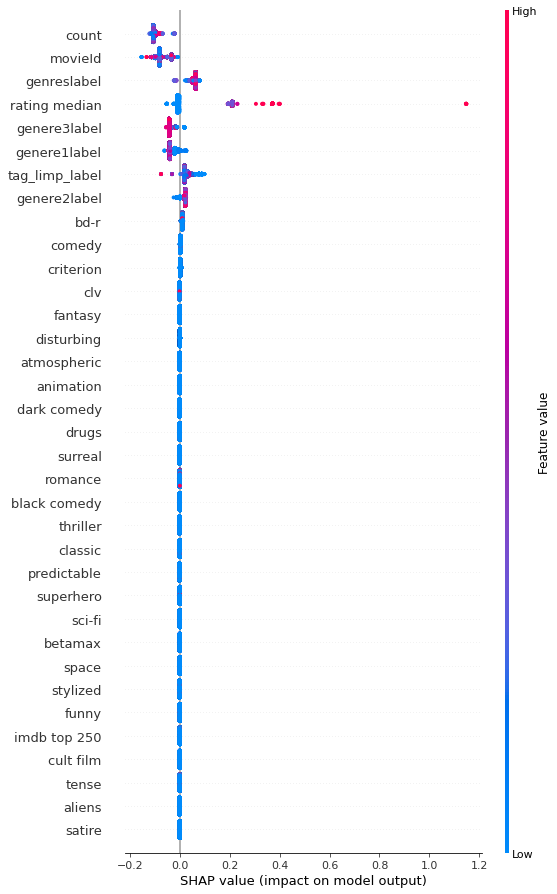

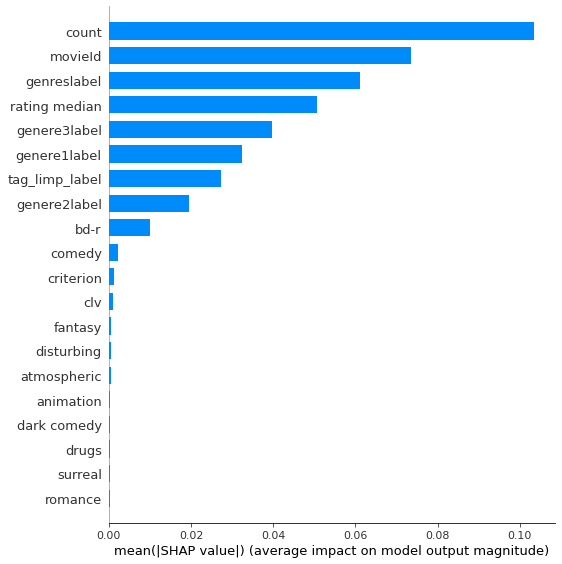

In [207]:
X_columns=X.columns
import shap
shap_values = shap.TreeExplainer(classifier_cl).shap_values(X_train)
shap.summary_plot(shap_values, X_train,X_columns,max_display =35)
shap.summary_plot(shap_values, X_columns,plot_type="bar")

Se puede observar que con las primer 10 variables que figuran en el grafico de barras podríamos mejorar el resultado

In [ ]:
# Lo cofirmamos con la correlación
correlacion=my_df_
corelation=correlacion.corr()
pl.figure(figsize = (30,10))
sns.heatmap(corelation, cmap="Blues",annot=True)

In [213]:
my_df_.columns

Index(['movieId', 'rating median', 'genreslabel', 'genere1label',
       'genere2label', 'genere3label', 'count', 'tag_limp_label', 'action',
       'adventure', 'aliens', 'animation', 'atmospheric', 'bd-r', 'betamax',
       'black comedy', 'classic', 'clv', 'comedy', 'criterion', 'cult film',
       'dark', 'dark comedy', 'disturbing', 'drama', 'drugs', 'dystopia',
       'fantasy', 'funny', 'imdb top 250', 'predictable', 'psychology',
       'quirky', 'romance', 'satire', 'sci-fi', 'space', 'stylized',
       'superhero', 'surreal', 'tense', 'thriller', 'time travel',
       'true story', 'twist ending', 'violence', 'world war ii', 'Target'],
      dtype='object')

In [231]:
my_df__v2=my_df_[['movieId', 'rating median','count','rating median','genreslabel','genere1label','genere2label','genere3label','tag_limp_label','Target']]

In [232]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import randint
#Get the Independent and Dependent Features

X = pd.DataFrame(my_df__v2.iloc[:, :-1]).values
y = pd.DataFrame(my_df__v2.iloc[:, -1]).values
params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
    
}

In [233]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [234]:
classifier=xgb.XGBClassifier()

random_search=RandomizedSearchCV(classifier,param_distributions=params)


from datetime import datetime
# Here we go
start_time = timer(None)
 # timing starts from this point for "start_time" variable
random_search.fit(X,y)

timer(start_time) # timing ends here for "start_time" variable


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



 Time taken: 0 hours 1 minutes and 1.08 seconds.


In [235]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0.4,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=5, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [236]:
classifier_cl = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0.4,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=5, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
classifier_cl=classifier_cl.fit(X_train_, y_train)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [237]:
y_pred_XGB = classifier_cl.predict(X_test_)
y_pred_XGB

array([0, 1, 1, ..., 0, 0, 0])

In [238]:
Matriz_Confusion(y_test, y_pred_XGB)

[[2280 2462]
 [2442 2093]]
Acurracy XGB: 0.4713808343214401
              precision    recall  f1-score   support

           0       0.48      0.48      0.48      4742
           1       0.46      0.46      0.46      4535

    accuracy                           0.47      9277
   macro avg       0.47      0.47      0.47      9277
weighted avg       0.47      0.47      0.47      9277

AUC XGB: 0.47116564217480883
sensibilidad 0.4615214994487321
especificidad 0.4808097849008857


(None, None, None, None, None, None)

In [ ]:
base_final=pd.concat([y_test.reset_index(drop=True),
                      pd.DataFrame(y_pred_XGB).reset_index(drop=True)], axis=1)
base_final
#y_test['Prediccion']=pd.DataFrame(y_pred_XGB)

In [ ]:
#Primer intento
AUC XGB: 0.47116564217480883
sensibilidad 0.4615214994487321
especificidad 0.4808097849008857
# Segundo intento feature selction y RandomizedSearchCV
AUC XGB: 0.46287516327621014
sensibilidad 0.41984564498346194
especificidad 0.5059046815689583

Para seguir mejorando los resultados se prodría:
*Obtener datos del perfil de cada persona que calificó las peliculas.
*Combinar las recomendaciones de las peliclas para inferir los gusos de cada personal, se tendría que modelar los datos y con get_dummies marcar los que tienen correlacion cada pelicula con un maximo de 3  peliculas

In [ ]:
# A continuacion dejo el código de ejemplo 

In [239]:
ratings_2 = pd.read_csv('rating.csv')
ratings_2.head

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [241]:
movies_2 = pd.read_csv('movie.csv')
movies_2=movies_2[['movieId','title']]

In [261]:
my_df_corr = pd.merge(ratings_2, movies_2, on='movieId')
my_df_corr=my_df_corr.head(500000)

In [262]:
uiim =pd.pivot_table(my_df_corr,index='userId', columns='title', values='rating')
uiim.head()

title,"City of Lost Children, The (Cité des enfants perdus, La) (1995)",Clerks (1994),Interview with the Vampire: The Vampire Chronicles (1994),Jumanji (1995),Léon: The Professional (a.k.a. The Professional) (Léon) (1994),"Mask, The (1994)",Pulp Fiction (1994),Rob Roy (1995),Rumble in the Bronx (Hont faan kui) (1995),Seven (a.k.a. Se7en) (1995),"Shawshank Redemption, The (1994)",Star Wars: Episode IV - A New Hope (1977),Twelve Monkeys (a.k.a. 12 Monkeys) (1995),"Usual Suspects, The (1995)",What's Eating Gilbert Grape (1993)
userId,,,,,,,,,,,,,,,
1,3.5,4.0,4.0,3.5,4.0,3.5,4.0,4.0,3.5,3.5,4.0,4.0,3.5,3.5,3.5
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN
3,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,5.0,4.0,5.0,3.0
4,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
5,NaN,NaN,NaN,3.0,NaN,3.0,NaN,NaN,NaN,NaN,5.0,5.0,NaN,NaN,NaN


In [258]:
  def find_corr(df_movies, movie_name): 
    similar_to_movie = df_movies.corrwith(uiim[movie_name])
    similar_to_movie = pd.DataFrame(similar_to_movie,columns=['Correlation'])
    similar_to_movie = similar_to_movie.sort_values(by = 'Correlation', ascending = False)
    return similar_to_movie
  

In [264]:
uiim.columns

Index(['City of Lost Children, The (Cité des enfants perdus, La) (1995)',
       'Clerks (1994)',
       'Interview with the Vampire: The Vampire Chronicles (1994)',
       'Jumanji (1995)',
       'Léon: The Professional (a.k.a. The Professional) (Léon) (1994)',
       'Mask, The (1994)', 'Pulp Fiction (1994)', 'Rob Roy (1995)',
       'Rumble in the Bronx (Hont faan kui) (1995)',
       'Seven (a.k.a. Se7en) (1995)', 'Shawshank Redemption, The (1994)',
       'Star Wars: Episode IV - A New Hope (1977)',
       'Twelve Monkeys (a.k.a. 12 Monkeys) (1995)',
       'Usual Suspects, The (1995)', 'What's Eating Gilbert Grape (1993)'],
      dtype='object', name='title')

In [280]:
movie_name = 'Clerks (1994)'
movie_name_corr=pd.DataFrame(find_corr(uiim, movie_name).head(3))
movie_name_corr


,Correlation
title,
Clerks (1994),1.000000
Pulp Fiction (1994),0.282546
"Usual Suspects, The (1995)",0.250283
